### The Needed Imports

In [1]:
import os

import datetime

import IPython

import IPython.display

import matplotlib as mpl

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import torch

import os

import requests

from torch.utils.data import Dataset, DataLoader

import zipfile

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

from itertools import product




## Data Prepocessing part

Get the dataset from the Jena climate dataset and sava it into csv file

In [2]:
# Define the URL and the filename

url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

filename = 'jena_climate_2009_2016.csv.zip'



# Download the file

response = requests.get(url)

with open(filename, 'wb') as f:

    f.write(response.content)



# Extract the ZIP file at the current directory

with zipfile.ZipFile(filename, 'r') as zip_ref:

    zip_ref.extractall()  



# Get the path of the extracted CSV file

csv_path = filename.replace('.zip', '')

print("CSV file extracted to:", csv_path)

CSV file extracted to: jena_climate_2009_2016.csv


Load the CSV file into a DataFrame

In [3]:
df = pd.read_csv(csv_path)

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')


In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.



There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

and it is easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [6]:
# Replace any negative values with zero in 'wv (m/s)' and 'max. wv (m/s)'

df['wv (m/s)'] = df['wv (m/s)'].where(df['wv (m/s)'] >= 0, 0.0)

df['max. wv (m/s)'] = df['max. wv (m/s)'].where(df['max. wv (m/s)'] >= 0, 0.0)



# Check the minimum values to ensure no negative values remain

df['wv (m/s)'].min(), df['max. wv (m/s)'].min()


(0.0, 0.0)

In [7]:
wv = df.pop('wv (m/s)')

max_wv = df.pop('max. wv (m/s)')



# Convert to radians.

wd_rad = df.pop('wd (deg)')*np.pi / 180



# Calculate the wind x and y components.

df['Wx'] = wv*np.cos(wd_rad)

df['Wy'] = wv*np.sin(wd_rad)



# Calculate the max wind x and y components.

df['max Wx'] = max_wv*np.cos(wd_rad)

df['max Wy'] = max_wv*np.sin(wd_rad)

### Extracting Time Features:



Convert the **Date Time** column from string to seconds. To capture daily and yearly patterns, use **sine and cosine transformations** to create "Time of day" and "Time of year" signal, making the data more model-friendy.s:

In [8]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [9]:
day = 24*60*60

year = (365.2425)*day



df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))

df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))

df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

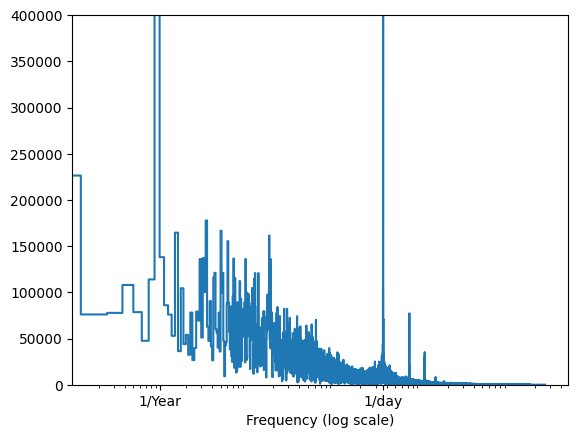

In [10]:
fft = np.fft.rfft(df['T (degC)'])

f_per_dataset = np.arange(0, len(fft))



# Calculate the sampling information

n_samples_h = len(df['T (degC)'])/6  ## as the data is sent every 10 min

hours_per_year = 24 * 365.2524

years_per_dataset = n_samples_h / hours_per_year



# Frequency per year

f_per_year = f_per_dataset / years_per_dataset



# Plotting

plt.step(f_per_year, np.abs(fft))

plt.xscale('log')

plt.ylim(0, 400000)

plt.xlim([0.1, max(plt.xlim())])

plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])

plt.xlabel('Frequency (log scale)')

plt.show()


### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:



1. It ensures that chopping the data into windows of consecutive samples is still possible.

2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}



n = len(df)

train_df = df[0:int(n*0.7)]

val_df = df[int(n*0.7):int(n*0.9)]

test_df = df[int(n*0.9):]



num_features = df.shape[1]

### Normalize the data



It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.


In [12]:
train_mean = train_df.mean()

train_std = train_df.std()



train_df = (train_df - train_mean) / train_std

val_df = (val_df - train_mean) / train_std

test_df = (test_df - train_mean) / train_std


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Model architecture

In [14]:
class TimeSeriesDataset(Dataset):

    def __init__(self, data, sequence_length):

        self.data = torch.tensor(data, dtype=torch.float32)

        self.sequence_length = sequence_length



    def __len__(self):

        return len(self.data) - self.sequence_length



    def __getitem__(self, idx):

        return self.data[idx: idx + self.sequence_length]



class WindowGenerator():

    def __init__(self, input_width, label_width, shift,

                 train_df, val_df, test_df, label_columns=None,batch_size=32):

        # Store the raw data

        self.train_df = train_df

        self.val_df = val_df

        self.test_df = test_df

        self.batch_size=batch_size

        # Work out the label column indices

        self.label_columns = label_columns

        if label_columns is not None:

            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}



        # Work out the window parameters

        self.input_width = input_width

        self.label_width = label_width

        self.shift = shift



        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)

        self.input_indices = np.arange(self.total_window_size)[self.input_slice]



        self.label_start = self.total_window_size - self.label_width

        self.labels_slice = slice(self.label_start, None)

        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]



    def __repr__(self):

        return '\n'.join([

            f'Total window size: {self.total_window_size}',

            f'Input indices: {self.input_indices}',

            f'Label indices: {self.label_indices}',

            f'Label column name(s): {self.label_columns}'])



    def split_window(self, features):

        inputs = features[:, self.input_slice, :]

        labels = features[:, self.labels_slice, :]

        

        if self.label_columns is not None:

            labels = torch.stack(

                [labels[:, :, self.column_indices[name]] for name in self.label_columns],

                dim=-1)

        

        return inputs, labels





    def make_dataset(self, data):

        # Convert the data to a float32 numpy array

        data = np.array(data, dtype=np.float32)



        # Create the TimeSeriesDataset with the appropriate sequence length

        dataset = TimeSeriesDataset(data, self.total_window_size)



        # Create a DataLoader for batching

        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)



        # Create a list to hold all batches

        all_batches = []



        # Iterate over the DataLoader and append batches to the list

        for batch in dataloader:

            all_batches.append(self.split_window(batch))  # Append each batch after processing



        return all_batches  # Return the list of all batches



    @property

    def train(self):

        return self.make_dataset(self.train_df)



    @property

    def val(self):

        return self.make_dataset(self.val_df)



    @property

    def test(self):

        return self.make_dataset(self.test_df)



    @property

    def example(self):

        """Get and cache an example batch of `inputs, labels` for plotting."""

        result = getattr(self, '_example', None)

        if result is None:

            # No example batch was found, so get one from the `.train` dataset

            for inputs, labels in self.train:  # Get a single batch from train

                result = (inputs, labels)  # Store the inputs and labels

                break  # We only want one batch

            # And cache it for next time

            self._example = result

        return result

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index].detach().cpu().numpy(),
                 label='Inputs', marker='.', zorder=-10)

        # Determine the correct label column index
            label_col_index = self.label_columns_indices.get(plot_col, plot_col_index) if self.label_columns else plot_col_index

            if label_col_index is not None:
                plt.scatter(self.label_indices, labels[n, :, label_col_index].detach().cpu().numpy(),
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index].detach().cpu().numpy(),
                        marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        plt.tight_layout()
        plt.show()




Define the needed windows:

In [15]:
single_step_window = WindowGenerator(

    input_width=1, 

    label_width=1, 

    shift=1, 

    train_df=train_df, 

    val_df=val_df, 

    test_df=test_df, 

    label_columns=['T (degC)'],

    batch_size=32

)

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [16]:
# Getting an example batch

example_inputs, example_labels = single_step_window.example

print(f'Inputs shape (batch, time, features): {example_inputs.shape}')

print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): torch.Size([32, 1, 19])
Labels shape (batch, time, features): torch.Size([32, 1, 1])


In [17]:
wide_window = WindowGenerator(

    input_width=24, 

    label_width=24, 

    shift=1, 

    train_df=train_df, 

    val_df=val_df, 

    test_df=test_df, 

    label_columns=['T (degC)'],

    batch_size=32

)



wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [18]:
# Getting an example batch

example_inputs, example_labels = wide_window.example

print(f'Inputs shape (batch, time, features): {example_inputs.shape}')

print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): torch.Size([32, 24, 19])
Labels shape (batch, time, features): torch.Size([32, 24, 1])


In [19]:
OUT_STEPS=24

multi_window = WindowGenerator(

    input_width=24, 

    label_width=OUT_STEPS, 

    shift=OUT_STEPS, 

    train_df=train_df, 

    val_df=val_df, 

    test_df=test_df, 

    label_columns=['T (degC)'],

    batch_size=32

)



multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

In [20]:
# Getting an example batch

example_inputs, example_labels = multi_window.example

print(f'Inputs shape (batch, time, features): {example_inputs.shape}')

print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): torch.Size([32, 24, 19])
Labels shape (batch, time, features): torch.Size([32, 24, 1])


### Baseline model

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.



This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.



So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.



![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [21]:
class Baseline(nn.Module):

    def __init__(self, label_index=None):

        super(Baseline, self).__init__()

        self.label_index = label_index



    def forward(self, inputs):
        inputs = inputs.to(device)

        if self.label_index is None:

            return inputs
        

        # Select the specified index along the last dimension

        result = inputs[:, :, self.label_index].unsqueeze(-1)

        return result



    def evaluate(self, dataloader, loss_fn, mae_fn):

        self.eval()  # Set the model to evaluation mode

        total_loss = 0

        total_mae = 0

        num_batches = 0  # Initialize a counter for batches



        with torch.no_grad():  # Disable gradient calculation

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)

                loss = loss_fn(outputs, labels)

                mae = mae_fn(outputs, labels)

                total_loss += loss.item()

                total_mae += mae.item()

                num_batches += 1  # Increment the batch counter



        # Average the loss and metrics over the dataset

        avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')

        avg_mae = total_mae / num_batches if num_batches > 0 else float('inf')



        return {'loss': avg_loss, 'mae': avg_mae}


### Dense


In [22]:
class DenseModel(nn.Module):

    def __init__(self):

        super(DenseModel, self).__init__()

        self.fc1 = nn.Linear(24 * 19, 64)  # Adjust input size as per your feature shape

        self.fc2 = nn.Linear(64, 64)

        self.fc3 = nn.Linear(64, 24)  # Output size matching time steps



    def forward(self, x):
        x = x.to(device)
        x = x.view(x.size(0), -1)  # Flatten the input

        x = torch.relu(self.fc1(x))

        x = torch.relu(self.fc2(x))

        x = self.fc3(x)

        return x.view(x.size(0), 24, 1)  # Reshape to (batch, time, features)



    def train_model(self, dataloader, optimizer, loss_fn, epochs=10):

        self.train()  # Set the model to training mode

        for epoch in range(epochs):

            total_loss = 0

            batch_count = 0

            for batch in dataloader:

                inputs, labels = batch  # Unpack the batch into inputs and labels
                inputs, labels = inputs.to(device), labels.to(device)


                # Ensure the correct input shape

                inputs = inputs[:, :24, :]  # Use first 24 time steps for inputs

                labels = labels[:, :24, :]  # Use all 24 time steps for labels

                

                optimizer.zero_grad()  # Clear gradients

                outputs = self(inputs)  # Forward pass

                

                # Compute loss

                loss = loss_fn(outputs, labels)

                total_loss += loss.item()

                batch_count += 1

                

                # Backward pass and optimization

                loss.backward()

                optimizer.step()

            

            avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')



    def evaluate(self, dataloader, loss_fn, mae_fn):

        self.eval()  # Set the model to evaluation mode

        total_loss = 0

        total_mae = 0

        batch_count = 0  # Initialize a batch counter



        with torch.no_grad():  # Disable gradient calculation

            for batch in dataloader:

                inputs, labels = batch  # Unpack the batch into inputs and labels

                inputs, labels = inputs.to(device), labels.to(device)

                # Ensure correct slicing

                inputs = inputs[:, :24, :]  # Adjust based on your input shape

                labels = labels[:, :24, :]  # Adjust based on your label shape



                outputs = self(inputs)

                loss = loss_fn(outputs, labels)

                mae = mae_fn(outputs, labels)



                total_loss += loss.item()

                total_mae += mae.item()

                batch_count += 1  # Increment batch counter



        # Average the loss and metrics over the dataset

        avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')

        avg_mae = total_mae / batch_count if batch_count > 0 else float('inf')



        return {'loss': avg_loss, 'mae': avg_mae}


### lstm model

In [ ]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, lstm_units, output_size):

        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, lstm_units, batch_first=True)

        self.fc = nn.Linear(lstm_units, output_size)



    def forward(self, x):
        x = x.to(device)
        lstm_out, _ = self.lstm(x) 

        # Apply the linear layer to each time step's output

        out = self.fc(lstm_out)  

        return out  # Output shape will be (batch_size, seq_length, output_size)



    def train_model(self, dataloader, optimizer, loss_fn, epochs=5):

        self.train()  # Set the model to training mode

        for epoch in range(epochs):

            total_loss = 0

            num_batches = 0 

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Clear gradients

                outputs = self(inputs)  # Forward pass

                loss = loss_fn(outputs, labels)  # Compute loss

                loss.backward()  # Backward pass

                optimizer.step()  # Update weights

                total_loss += loss.item()

                num_batches += 1  




            avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')



    def evaluate(self, dataloader, loss_fn, mae_fn):

        self.eval()  # Set the model to evaluation mode

        total_loss = 0

        total_mae = 0

        num_batches = 0  # Initialize batch counter



        with torch.no_grad():  # Disable gradient calculation

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self(inputs)  # Forward pass

                loss = loss_fn(outputs, labels)  # Compute loss

                mae = mae_fn(outputs, labels)  # Compute mean absolute error



                total_loss += loss.item()

                total_mae += mae.item()

                num_batches += 1  # Increment batch counter



        # Average the loss and metrics over the dataset

        avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')

        avg_mae = total_mae / num_batches if num_batches > 0 else float('inf')



        return {'loss': avg_loss, 'mae': avg_mae}


## Training and evaluation

In [24]:
val_performance = {}

performance = {}

In [ ]:
# for baseline model:

baseline = Baseline(label_index=column_indices['T (degC)']).to(device)



# Define loss function and metrics

loss_fn = nn.MSELoss()  

mae_fn = nn.L1Loss()    



# Evaluate on validation and test sets

val_performance['Baseline'] = baseline.evaluate(single_step_window.val,loss_fn,mae_fn)

performance['Baseline'] = baseline.evaluate(single_step_window.test,loss_fn,mae_fn)



# Print the performance metrics

print("Validation Performance:", val_performance['Baseline'])

print("Test Performance:", performance['Baseline'])


Validation Performance: {'loss': 0.0007708273143464144, 'mae': 0.018011423296158013}
Test Performance: {'loss': 0.0008569703487959999, 'mae': 0.01968289576612498}


This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:



![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

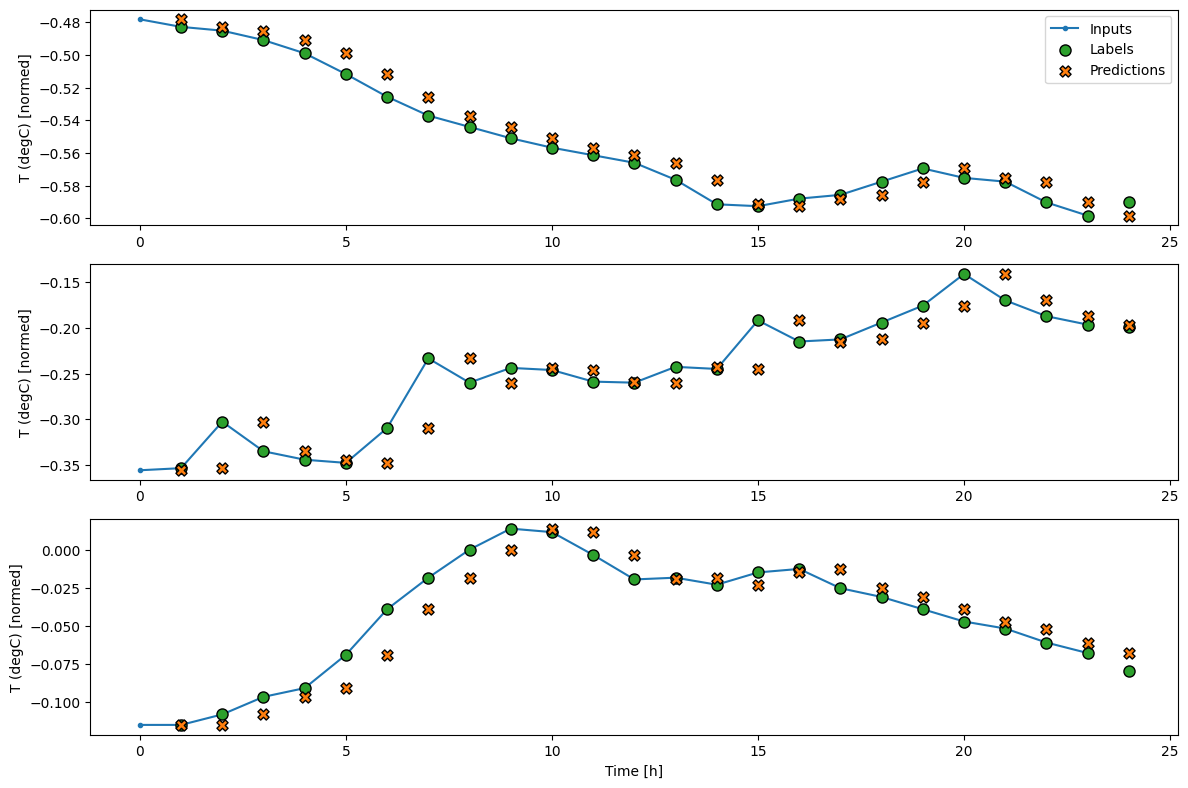

In [26]:
wide_window.plot(baseline)

In [27]:
# for dense model

dense_model = DenseModel().to(device)



# Loss and optimizer

loss_fn = nn.MSELoss()  

mae_fn = nn.L1Loss()  

epochs=5

optimizer = optim.Adam(dense_model.parameters(), lr=0.001)



# Train the model

dense_model.train_model( wide_window.train,optimizer,loss_fn,epochs)



val_performance['DENSE'] = dense_model.evaluate( wide_window.val,loss_fn,mae_fn)

performance['DENSE'] = dense_model.evaluate(wide_window.test,loss_fn,mae_fn)



# Print the performance metrics

print("Validation Performance:", val_performance['DENSE'])

print("Test Performance:", performance['DENSE'])


Epoch 1/5, Loss: 0.0025
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0003
Epoch 4/5, Loss: 0.0003
Epoch 5/5, Loss: 0.0002
Validation Performance: {'loss': 0.00015280629323850898, 'mae': 0.008505238556760948}
Test Performance: {'loss': 0.00016220026847037637, 'mae': 0.008844806997337955}


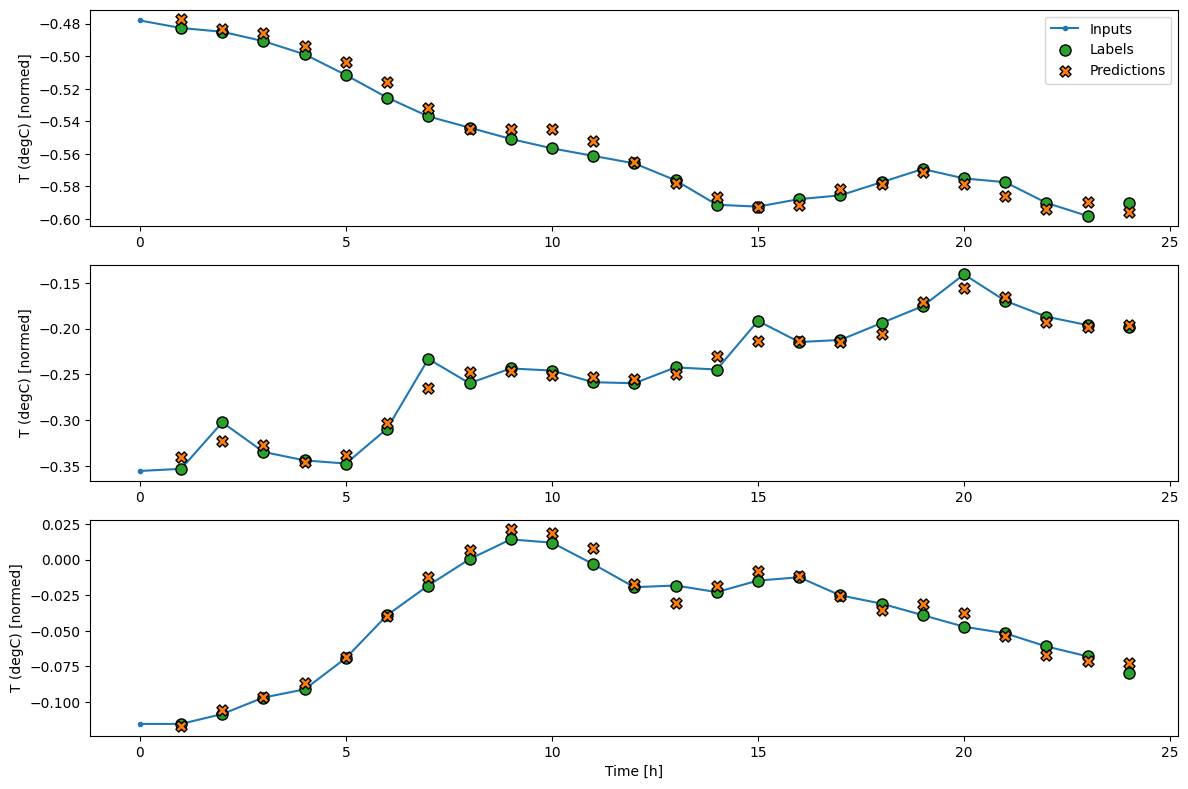

In [28]:
wide_window.plot(dense_model)

In [29]:
# for lstm model

input_size = 19  

lstm_units = 32

output_size = 1

epochs=5

lstm_model = LSTMModel(input_size, lstm_units, output_size).to(device)

# Define the loss function and optimizer

loss_fn = nn.MSELoss()  

optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

lstm_model.train_model( wide_window.train,optimizer, loss_fn, epochs)



# Evaluate the model

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, loss_fn, mae_fn)

performance['LSTM'] = lstm_model.evaluate(wide_window.test, loss_fn, mae_fn)



# Print the performance metrics

print("Validation Performance:", val_performance['LSTM'])

print("Test Performance:", performance['LSTM'])

Epoch 1/5, Loss: 0.0042
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0005
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0005
Validation Performance: {'loss': 0.00047119229690894193, 'mae': 0.014449760925217534}
Test Performance: {'loss': 0.0005105748315952375, 'mae': 0.015340612620778689}


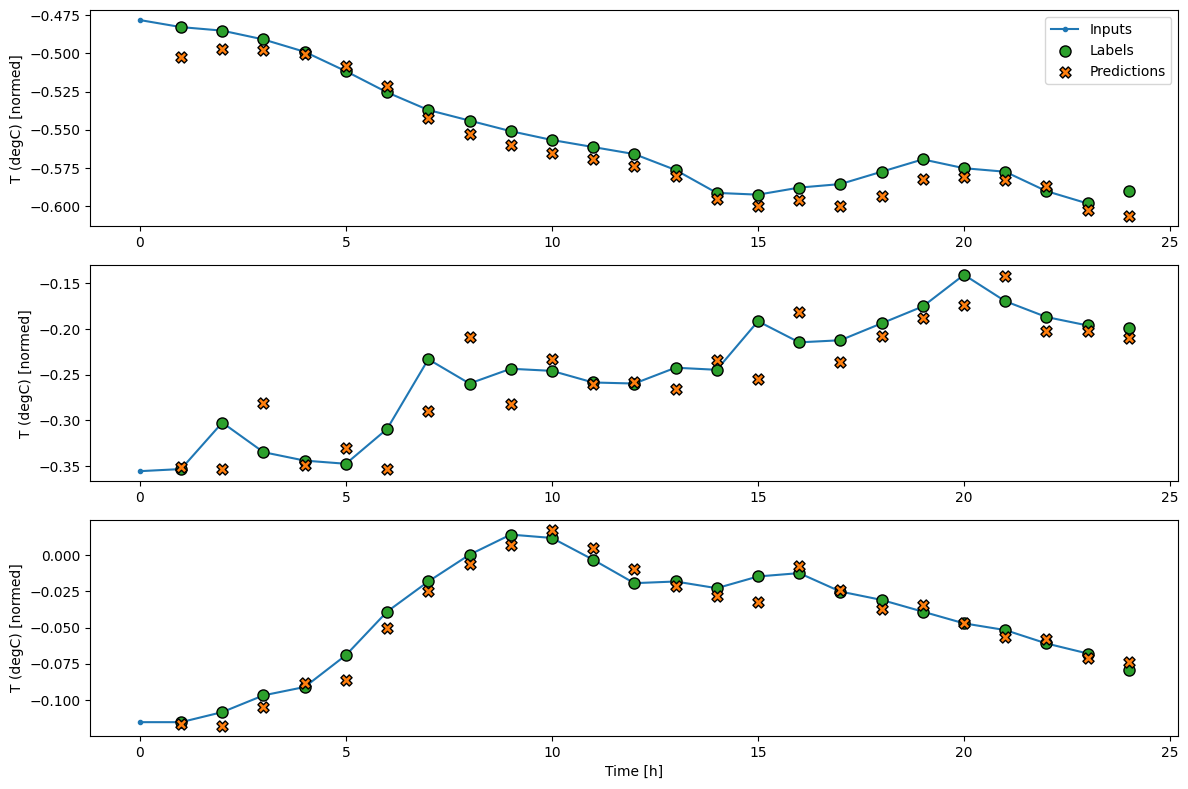

In [30]:
wide_window.plot(lstm_model)

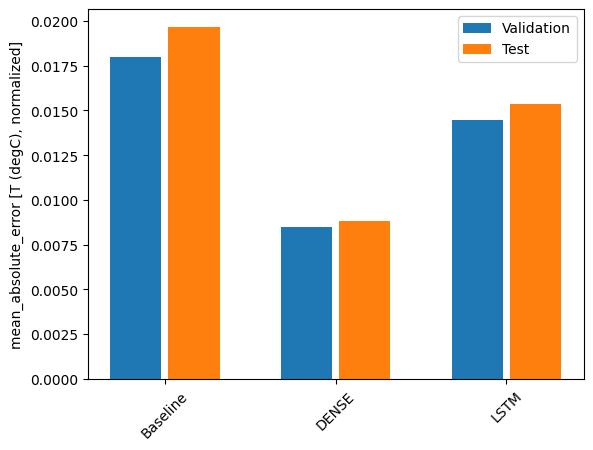

In [31]:
x = np.arange(len(performance))

width = 0.3

metric_name = 'mae'

val_mae = [v[metric_name] for v in val_performance.values()]

test_mae = [v[metric_name] for v in performance.values()]



plt.ylabel('mean_absolute_error [T (degC), normalized]')

plt.bar(x - 0.17, val_mae, width, label='Validation')

plt.bar(x + 0.17, test_mae, width, label='Test')

plt.xticks(ticks=x, labels=performance.keys(),

           rotation=45)

_ = plt.legend()

## Hyperparameter tuning part:



- for dense model

In [ ]:
# Define the hyperparameter space

learning_rates = [0.001, 0.0001]  

epochs_list = [5]  

batch_sizes = [16, 32]  



best_val_loss = float('inf')  

best_params = {}



# Hyperparameter tuning loop

for lr, epochs, batch_size in product(learning_rates, epochs_list, batch_sizes):

    # Create a new instance of the model for each hyperparameter combination

    dense_model = DenseModel().to(device)

    

    # Loss functions and optimizer

    loss_fn = nn.MSELoss()

    mae_fn = nn.L1Loss()

    optimizer = optim.Adam(dense_model.parameters(), lr=lr)



    data_loader = WindowGenerator(input_width=24, label_width=24,  shift=1, train_df=train_df, val_df=val_df, test_df=test_df,

                    label_columns=['T (degC)'],batch_size=batch_size)



    # Train the model

    dense_model.train_model(data_loader.train, optimizer, loss_fn, epochs)



    # Evaluate on validation set

    val_metrics = dense_model.evaluate(data_loader.val, loss_fn, mae_fn)

    val_loss = val_metrics['loss']  



    # Track the best hyperparameters based on validation loss

    if val_loss < best_val_loss:

        best_val_loss = val_loss

        best_params = {

            'learning_rate': lr,

            'epochs': epochs,

            'batch_size': batch_size

        }

    print("--------------------------------------------------------------------------------------")


# Initialize the data loader
data_loader = WindowGenerator(input_width=24, label_width=24, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
                              label_columns=['T (degC)'], batch_size=best_params['batch_size'])

# Initialize loss functions
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

# Initialize the model and move it to the device (GPU or CPU)
final_model = DenseModel().to(device)

# Set optimizer
print(best_params['learning_rate'])
print(best_params['epochs'])
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# Train the model with the best parameters
final_model.train_model(data_loader.train, optimizer, loss_fn, best_params['epochs'])

# Evaluate on test set
performance = {}
performance['DENSE'] = final_model.evaluate(data_loader.test, loss_fn, mae_fn)

# Print the performance metrics and best parameters
print("Validation Performance:", val_metrics)
print("Test Performance:", performance)
print("Best Hyperparameters:", best_params)

Epoch 1/5, Loss: 0.0018
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0003
Epoch 4/5, Loss: 0.0003
Epoch 5/5, Loss: 0.0003
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0024
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0003
Epoch 4/5, Loss: 0.0002
Epoch 5/5, Loss: 0.0002
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0055
Epoch 2/5, Loss: 0.0004
Epoch 3/5, Loss: 0.0002
Epoch 4/5, Loss: 0.0002
Epoch 5/5, Loss: 0.0002
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0113
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0003
Epoch 4/5, Loss: 0.0003
Epoch 5/5, Loss: 0.0002
--------------------------------------------------------------------------------------
0.0001
5
Epoch 1/5, Loss: 0.0054
Epoch 2/5, Loss: 0.0004
Epoch 3/5, Loss: 0.0003
Epoch 4/5, Loss: 0.0002
Epoch 5/5, Loss: 0.0002
Validation Performance: {'loss': 0.00018252

- for lstm model 

In [ ]:
# Define the hyperparameter space

lstm_units_list = [16, 32]  # Different LSTM units to try

learning_rates = [0.001, 0.0001]  

epochs_list = [5]  

batch_sizes = [16, 32]  



best_val_loss = float('inf')  

best_params = {}



# Hyperparameter tuning loop

for lstm_units, lr, epochs, batch_size in product(lstm_units_list, learning_rates, epochs_list, batch_sizes):

    # Create a new instance of the model for each hyperparameter combination

    lstm_model = LSTMModel(input_size=19, lstm_units=lstm_units, output_size=1).to(device)

    

    # Loss function and optimizer

    loss_fn = nn.MSELoss()

    mae_fn = nn.L1Loss()

    optimizer = optim.Adam(lstm_model.parameters(), lr=lr)

    # Create DataLoader for training data

    data_loader = WindowGenerator(input_width=24, label_width=24,  shift=1, train_df=train_df, val_df=val_df, test_df=test_df,

                    label_columns=['T (degC)'],batch_size=batch_size)

    # Train the model

    lstm_model.train_model(data_loader.train, optimizer, loss_fn, epochs)

    # Evaluate on validation set

    val_metrics = lstm_model.evaluate(data_loader.val, loss_fn, mae_fn)

    val_loss = val_metrics['loss']  



    # Track the best hyperparameters based on validation loss

    if val_loss < best_val_loss:

        best_val_loss = val_loss

        best_params = {

            'lstm_units': lstm_units,

            'learning_rate': lr,

            'epochs': epochs,

            'batch_size': batch_size

        }

    print("--------------------------------------------------------------------------------------")

# Initialize the data loader
data_loader = WindowGenerator(input_width=24, label_width=24, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
                              label_columns=['T (degC)'], batch_size=best_params['batch_size'])

# Initialize loss functions
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

final_lstm_model = LSTMModel(input_size=19, lstm_units=best_params['lstm_units'], output_size=1).to(device)

# Set optimizer
optimizer = optim.Adam(final_lstm_model.parameters(), lr=best_params['learning_rate'])

# Train the model with the best parameters
final_lstm_model.train_model(data_loader.train, optimizer, loss_fn, best_params['epochs'])

# Evaluate on the test set
performance['LSTM'] = final_lstm_model.evaluate(data_loader.test, loss_fn, mae_fn)

# Print the performance metrics and best parameters
print("Validation Performance:", val_metrics)
print("Test Performance:", performance)
print("Best Hyperparameters:", best_params)

        

Epoch 1/5, Loss: 0.0044
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0005
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0005
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0067
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0005
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0005
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0305
Epoch 2/5, Loss: 0.0006
Epoch 3/5, Loss: 0.0005
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0005
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0609
Epoch 2/5, Loss: 0.0007
Epoch 3/5, Loss: 0.0005
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0005
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0022
Epoch 2/5, Loss: 0.0005
Epoch 3/5, Loss: 0.0005
Epoch 4/5, Loss: 0.0005
Epoch 5/5, Loss: 0.0005
----------------------------------------------------

## Multi-step models



Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.



This section looks at how to expand these models to make **multiple time step predictions**.



In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.



In this section all the models will predict **all the features across all output time steps**.



Define MultiStepLastBaseline

In [ ]:
class MultiStepLastBaseline(nn.Module):

    def __init__(self, out_steps):

        super(MultiStepLastBaseline, self).__init__()

        self.out_steps = out_steps



    def forward(self, inputs):

        inputs = inputs.to(device)
        return inputs[:, -1:, :][:, :, :1].expand(-1, self.out_steps, -1)  



    def evaluate(self, dataloader, loss_fn, mae_fn):

        self.eval()

        total_loss = 0

        total_mae = 0

        with torch.no_grad():

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = self(inputs)

                loss = loss_fn(predictions, labels)

                mae = mae_fn(predictions, labels)

                total_loss += loss.item()

                total_mae += mae.item()

        avg_loss = total_loss / len(dataloader)

        avg_mae = total_mae / len(dataloader)

        return {'MSE': avg_loss, 'MAE': avg_mae}


Define RepeatBaseline

In [ ]:
class RepeatBaseline(nn.Module):

    def forward(self, inputs):

        inputs = inputs.to(device)
        return inputs[:, -24:, 1].unsqueeze(-1)  



    def evaluate(self, dataloader, mse_loss_fn, mae_loss_fn):

        self.eval()  # Set the model to evaluation mode

        total_mse_loss = 0

        total_mae_loss = 0

        with torch.no_grad():  # Disable gradient calculation

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = self(inputs)  # Use the forward method for predictions

                # Compute Mean Squared Error and Mean Absolute Error

                mse_loss = mse_loss_fn(predictions, labels)  # Calculate MSE loss

                mae_loss = mae_loss_fn(predictions, labels)  # Calculate MAE loss

                total_mse_loss += mse_loss.item()  # Accumulate MSE loss

                total_mae_loss += mae_loss.item()  # Accumulate MAE loss

        

        # Average loss calculations

        avg_mse_loss = total_mse_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

        avg_mae_loss = total_mae_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

        

        return {"MSE": avg_mse_loss, "MAE": avg_mae_loss}  # Return average losses


Define MultiLSTMModel

In [ ]:
class MultiLSTMModel(nn.Module):

    def __init__(self, out_steps):

        super(MultiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=19, hidden_size=32, batch_first=True)

        self.dense = nn.Linear(32, out_steps)  

        self.out_steps = out_steps



    def forward(self, x):

        # Pass through LSTM layer
        x = x.to(device)

        lstm_out, _ = self.lstm(x)  # Shape after LSTM: [batch, time, lstm_units]

        

        # Take the last LSTM output for each sequence

        last_output = lstm_out[:, -1, :]  # Shape: [batch, lstm_units]

        

        # Pass through Dense layer

        dense_out = self.dense(last_output)  # Shape: [batch, out_steps * 1]

        

        # Reshape to [batch, out_steps, 1]

        output = dense_out.view(-1, self.out_steps, 1)

        return output 



    def train_model(self, dataloader, optimizer, mse_loss_fn, epochs):

        self.train()  # Set the model to training mode

        for epoch in range(epochs):

            total_loss = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()  # Clear gradients

                predictions = self(inputs)  # Forward pass

                loss = mse_loss_fn(predictions, labels)  # Compute loss

                loss.backward()  # Backward pass

                optimizer.step()  # Update weights

                total_loss += loss.item()  # Accumulate loss

            

            avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")



    def evaluate(self, dataloader, mse_loss_fn, mae_loss_fn):

        self.eval()  # Set the model to evaluation mode

        total_mse_loss = 0

        total_mae_loss = 0

        with torch.no_grad():

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = self(inputs)  # Forward pass

                # Compute Mean Squared Error and Mean Absolute Error

                mse_loss = mse_loss_fn(predictions, labels)  # Calculate MSE loss

                mae_loss = mae_loss_fn(predictions, labels)  # Calculate MAE loss

                total_mse_loss += mse_loss.item()  # Accumulate MSE loss

                total_mae_loss += mae_loss.item()  # Accumulate MAE loss

        

        avg_mse_loss = total_mse_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

        avg_mae_loss = total_mae_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

        

        return {"MSE": avg_mse_loss, "MAE": avg_mae_loss}  # Return average losses

## Training and evaluation

In [ ]:

multi_val_performance = {}

multi_performance = {}

In [39]:
# for MultiStepLastBaseline

OUT_STEPS = 24  

last_baseline = MultiStepLastBaseline(out_steps=OUT_STEPS).to(device)



# Define the loss function and metrics

mse_loss_fn = nn.MSELoss()  # Mean Squared Error

mae_loss_fn = nn.L1Loss()  # Mean Absolute Error



# Evaluate on validation and test sets

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val,mse_loss_fn,mae_loss_fn)

multi_performance['Last'] = last_baseline.evaluate(multi_window.test,mse_loss_fn,mae_loss_fn)



# Print the performance metrics

print("Validation Performance:", multi_val_performance['Last'])

print("Test Performance:", multi_performance['Last'])

Validation Performance: {'MSE': 1.940154745386361, 'MAE': 1.1425511450834678}
Test Performance: {'MSE': 2.170630962904954, 'MAE': 1.1602465989747668}


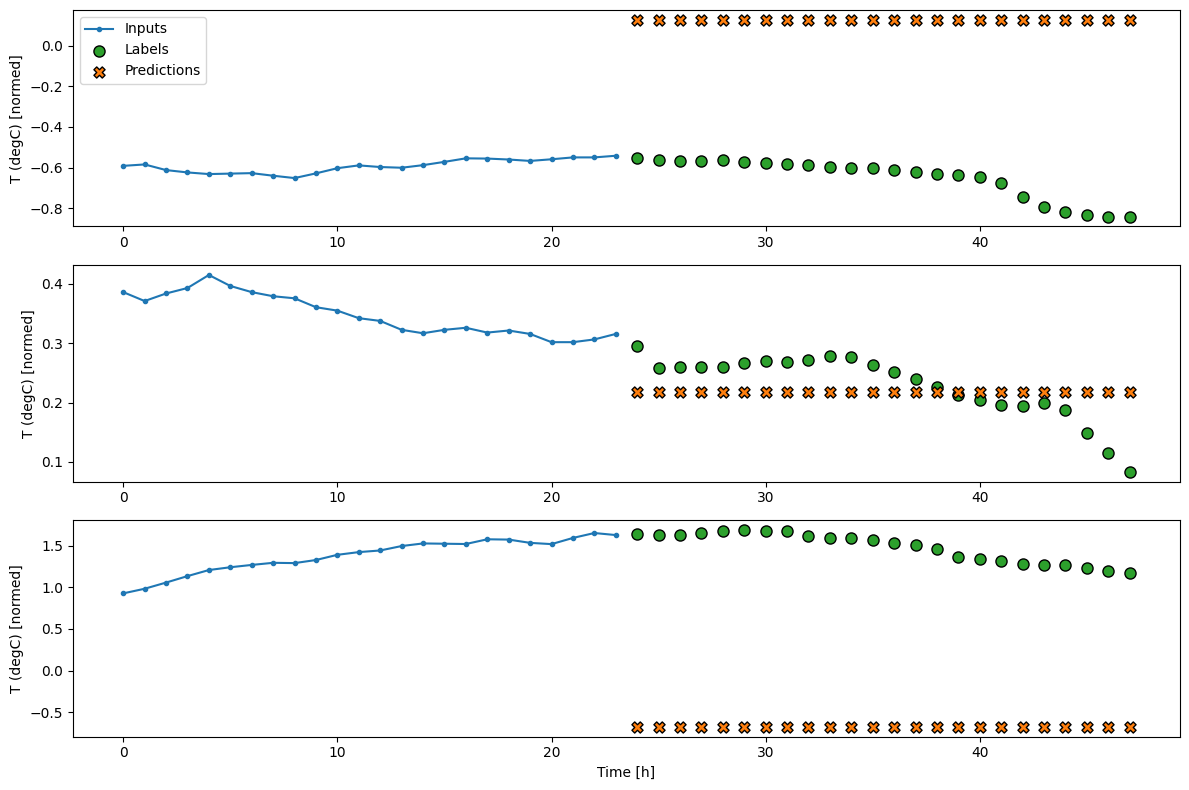

In [ ]:
multi_window.plot(last_baseline) 


In [41]:
# for RepeatBaseline

repeat_baseline = RepeatBaseline().to(device)



# Define loss functions

mse_loss_fn = nn.MSELoss()

mae_loss_fn = nn.L1Loss()

multi_val_performance['Repeat'] = repeat_baseline.evaluate( multi_window.val,mse_loss_fn,mae_loss_fn)

multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test,mse_loss_fn,mae_loss_fn)



# Print performance metrics

print("Validation Performance:", multi_val_performance['Repeat'])

print("Test Performance:", multi_performance['Repeat'])


Validation Performance: {'MSE': 0.12320541788699466, 'MAE': 0.25670010566166884}
Test Performance: {'MSE': 0.14242368528827945, 'MAE': 0.2853237640081429}


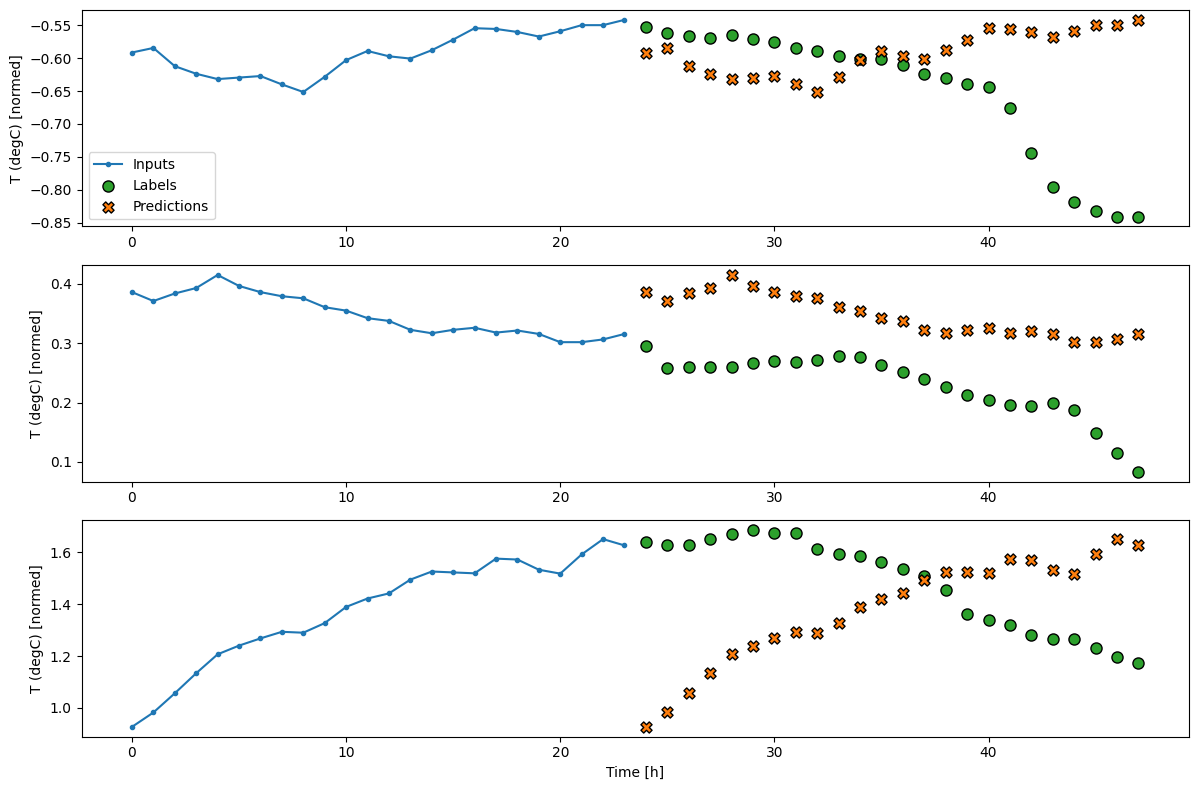

In [42]:
multi_window.plot(repeat_baseline)

In [43]:
# for the MultiLST model

OUT_STEPS = 24  # Number of output steps

multi_lstm_model = MultiLSTMModel(OUT_STEPS).to(device)


# Define the optimizer

learning_rate = 0.001

optimizer = optim.Adam(multi_lstm_model.parameters(), lr=learning_rate)

# Define loss functions

mse_loss_fn = nn.MSELoss()

mae_loss_fn = nn.L1Loss()

epochs = 5  

# Train the model

multi_lstm_model.train_model( multi_window.train, optimizer,mse_loss_fn,epochs)



# Evaluate the model on validation and test data

multi_val_performance['LSTM'] = multi_lstm_model.evaluate( multi_window.val,mse_loss_fn,mae_loss_fn)

multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test,mse_loss_fn,mae_loss_fn)



# Print performance metrics

print("Validation Performance:", multi_val_performance['LSTM'])

print("Test Performance:", multi_performance['LSTM'])


Epoch [1/5], Loss: 0.0216
Epoch [2/5], Loss: 0.0141
Epoch [3/5], Loss: 0.0133
Epoch [4/5], Loss: 0.0128
Epoch [5/5], Loss: 0.0125
Validation Performance: {'MSE': 0.014357109111317174, 'MAE': 0.08027906858953951}
Test Performance: {'MSE': 0.013888290993194042, 'MAE': 0.07991191256232417}


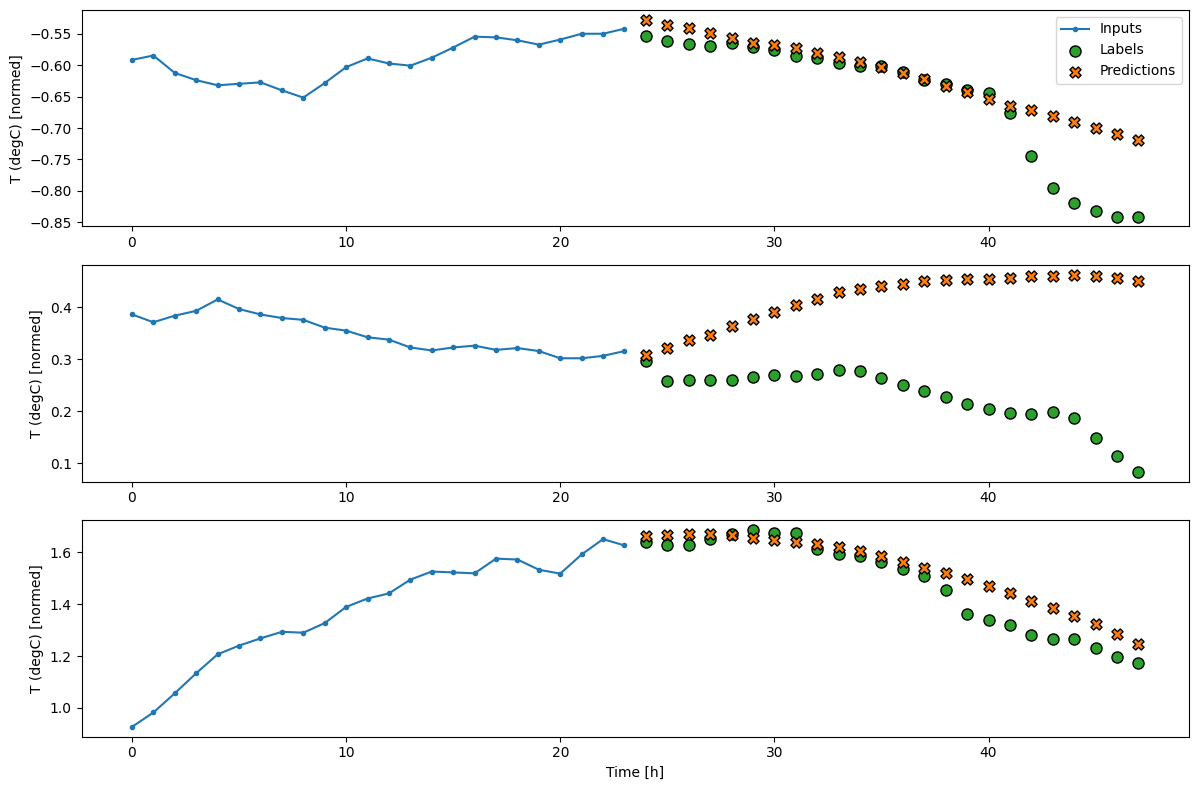

In [44]:
multi_window.plot(multi_lstm_model) 


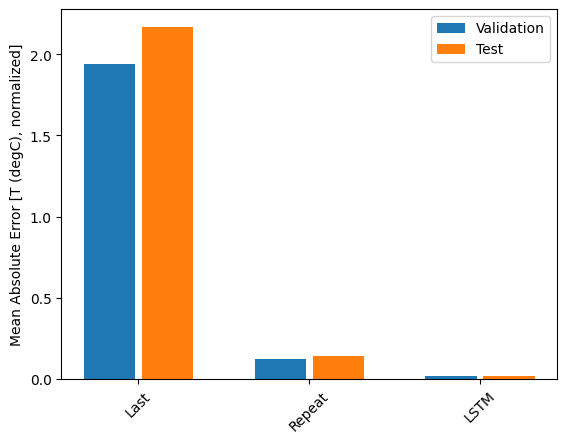

In [45]:
x = np.arange(len(multi_val_performance))

width = 0.3

metric_name = 'MSE'



# Extract MSE values safely, handling cases where values are not dictionaries

val_mae = [v[metric_name] if isinstance(v, dict) else v for v in multi_val_performance.values()]

test_mae = [v[metric_name] if isinstance(v, dict) else v for v in multi_performance.values()]



plt.ylabel('Mean Absolute Error [T (degC), normalized]')

plt.bar(x - 0.17, val_mae, width, label='Validation')

plt.bar(x + 0.17, test_mae, width, label='Test')

plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)

plt.legend()

plt.show()

## Hyperparameter tuning part:


for MultiLSTMModel

In [ ]:
# Define the lists of hyperparameters
lstm_units_list = [16, 32] 
learning_rates = [0.001, 0.0001]  
epochs_list = [5] 
batch_sizes = [16, 32] 

# Initialize best parameters
best_val_loss = float('inf')
best_params = {}

# Hyperparameter tuning loop
for lstm_units, lr, epochs, batch_size in product(lstm_units_list, learning_rates, epochs_list, batch_sizes):

    # Create a new instance of the model for each hyperparameter combination
    lstm_model = LSTMModel(input_size=19, lstm_units=lstm_units, output_size=1).to(device)
    
    # Loss function and optimizer
    loss_fn = nn.MSELoss()
    mae_fn = nn.L1Loss()
    optimizer = optim.Adam(lstm_model.parameters(), lr=lr)

    # Create DataLoader for training data
    data_loader = WindowGenerator(input_width=24, label_width=24, shift=24, train_df=train_df, val_df=val_df, test_df=test_df, 
                                  label_columns=['T (degC)'], batch_size=batch_size)

    # Train the model
    lstm_model.train_model(data_loader.train, optimizer, loss_fn, epochs)

    # Evaluate on validation set
    val_metrics = lstm_model.evaluate(data_loader.val, loss_fn, mae_fn)
    val_loss = val_metrics['loss']  

    # Track the best hyperparameters based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {
            'lstm_units': lstm_units,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size
        }

    print(f"Tested LSTM units: {lstm_units}, Learning rate: {lr}, Batch size: {batch_size}, Validation loss: {val_loss:.4f}")
    print("--------------------------------------------------------------------------------------")

# Create DataLoader for final training with the best batch size
data_loader = WindowGenerator(input_width=24, label_width=24, shift=24, train_df=train_df, val_df=val_df, test_df=test_df,
                              label_columns=['T (degC)'], batch_size=best_params['batch_size'])
# Initialize loss functions
loss_fn = nn.MSELoss()
mae_fn = nn.L1Loss()

# Instantiate the final LSTM model with the best parameters
final_lstm_model = LSTMModel(input_size=19, lstm_units=best_params['lstm_units'], output_size=1).to(device)

# Train the final model
optimizer = optim.Adam(final_lstm_model.parameters(), lr=best_params['learning_rate'])
# Train the model with the best parameters
final_lstm_model.train_model(data_loader.train, optimizer, loss_fn, best_params['epochs'])

# Evaluate on the test set
performance['LSTM'] = final_lstm_model.evaluate(data_loader.test, loss_fn, mae_fn)

# Print the performance metrics and best parameters
print("Validation Performance:", val_metrics)
print("Test Performance:", performance)
print("Best Hyperparameters:", best_params)


Epoch 1/5, Loss: 0.0359
Epoch 2/5, Loss: 0.0294
Epoch 3/5, Loss: 0.0285
Epoch 4/5, Loss: 0.0279
Epoch 5/5, Loss: 0.0274
Tested LSTM units: 16, Learning rate: 0.001, Batch size: 16, Validation loss: 0.0300
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0412
Epoch 2/5, Loss: 0.0295
Epoch 3/5, Loss: 0.0286
Epoch 4/5, Loss: 0.0281
Epoch 5/5, Loss: 0.0277
Tested LSTM units: 16, Learning rate: 0.001, Batch size: 32, Validation loss: 0.0304
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.0711
Epoch 2/5, Loss: 0.0339
Epoch 3/5, Loss: 0.0320
Epoch 4/5, Loss: 0.0311
Epoch 5/5, Loss: 0.0305
Tested LSTM units: 16, Learning rate: 0.0001, Batch size: 16, Validation loss: 0.0312
--------------------------------------------------------------------------------------
Epoch 1/5, Loss: 0.1003
Epoch 2/5, Loss: 0.0355
Epoch 3/5, Loss: 0.0328
Epoch 4/5, Loss: 0.0318
Epoch 5/5, Loss: 0.0311
Tes